# Just Object Classification with Transfer Learning Demo Project
Here you can go through my demo project that uses pretrained Resnet that is being finetuned with [Garbage Classification dataset](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification). This notebook is just given to demonstrate basic concepts of Object Classification with Transfer Learning and their implementation using Pytorch.

Importing all necessary packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import shutil
import random
from tqdm import tqdm
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.autograd import Variable
from hydra import initialize, compose
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import MulticlassF1Score
%matplotlib inline

We will use a custom dataset of Garbage images which consists of 2500 color images of garbage that are distributed into 6 classes (one of them is called "trash" meaning that it doesn't belong to other 5 classes given. 

In [2]:
from utils import GarbageDataset

Initializing a config object:

In [3]:
with initialize(version_base=None, config_path="."):
  config = compose(config_name="config")

Then we need to define train, validation and test datasets in order to use them further. 

First of all, we define some basic transformations to make images suitable for our model. Here we will use Albumentations library which contains a lot of different transformations and augumentation options:

We also divide our entire dataset into a train, validation, and test subsets while initializing dataset objects. We will use them to prepare `DataLoader`'s further.

In [4]:


train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        ToTensorV2(),
    ]
)
train_dataset = GarbageDataset(transform=train_transform, multiplier=1.0-config.data.validation_multiplier)

It's a correct way to use only simple augumentations and transformations on both test and validation datasets since their data should be clear to represent a "real world" data.

In [5]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        ToTensorV2(),
    ]
)
val_dataset = GarbageDataset(transform=val_transform, multiplier=config.data.validation_multiplier)
test_dataset = GarbageDataset(transform=val_transform, multiplier=config.data.validation_multiplier)

Building all needed `DataLoader`s

In [7]:
train_data = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=config.data.batch_size, 
    shuffle=True,
    num_workers=config.data.num_workers
)
val_data = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=config.data.batch_size,
    shuffle=True,
    num_workers=config.data.num_workers
)
test_data = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.data.batch_size,
    num_workers=config.data.num_workers
)

All supporting functions are imported from an `utils.py` module below:

In [3]:
from utils import imshow, train, test, get_val_f1

Let's preview some images from a train dataset

/tmp/ipykernel_19421/2637703082.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541990/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  ax.ravel()[i].imshow(image.T)


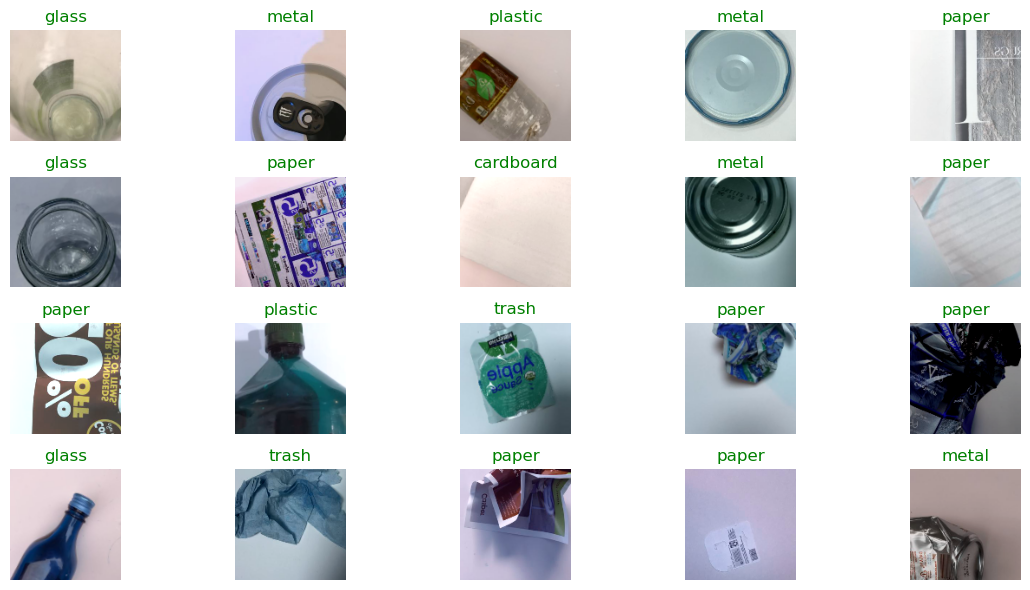

In [9]:
from utils import imshow

samples = next(iter(train_data))
imshow(samples)

We will use `ResNet` model as a baseline because it's a good choice for image classificaiton problems (i.e. our config states for `resnet152`):


In [10]:
model = getattr(models, config.model.baseline)(weights=config.model.weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We also need to make a modification of the last (fully connected) layer of our network model since we have only a particular number of output classes):

In [11]:
model.fc = nn.Linear(model.fc.in_features, len(test_dataset.classes))

We also use Cross Entropy loss as our lost function, SDG optimizer and a step learning rate scheduler that will decrease a learning rate after some step (defined in a config file)):

In [19]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.model.learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.model.step_size, gamma=0.1)

Main cell that goes through 5 epochs of training process using a CUDA device

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train(config.model.num_epochs)
print("Training Finished")

The model will be running on cuda:0 device


100%|██████████| 102/102 [00:14<00:00,  7.19it/s]


Epoch: 1    F1 Score: 0.3984759449958801


100%|██████████| 102/102 [00:13<00:00,  7.29it/s]


Epoch: 2    F1 Score: 0.5130143761634827


100%|██████████| 102/102 [00:14<00:00,  7.27it/s]


Epoch: 3    F1 Score: 0.5752992630004883


100%|██████████| 102/102 [00:14<00:00,  7.28it/s]


Epoch: 4    F1 Score: 0.6117545366287231


100%|██████████| 102/102 [00:13<00:00,  7.31it/s]


Epoch: 5    F1 Score: 0.6612105369567871


100%|██████████| 102/102 [00:13<00:00,  7.30it/s]


Epoch: 6    F1 Score: 0.7738906741142273


100%|██████████| 102/102 [00:13<00:00,  7.31it/s]


Epoch: 7    F1 Score: 0.7682375311851501


100%|██████████| 102/102 [00:14<00:00,  7.28it/s]


Epoch: 8    F1 Score: 0.6223153471946716


100%|██████████| 102/102 [00:14<00:00,  7.27it/s]


Epoch: 9    F1 Score: 0.8075476288795471


100%|██████████| 102/102 [00:14<00:00,  7.27it/s]


Epoch: 10    F1 Score: 0.8288679718971252


100%|██████████| 102/102 [00:13<00:00,  7.29it/s]


Epoch: 11    F1 Score: 0.8572571277618408


100%|██████████| 102/102 [00:14<00:00,  7.26it/s]


Epoch: 12    F1 Score: 0.8450543880462646


100%|██████████| 102/102 [00:14<00:00,  7.27it/s]


Epoch: 13    F1 Score: 0.872909665107727


100%|██████████| 102/102 [00:13<00:00,  7.30it/s]


Epoch: 14    F1 Score: 0.8823477029800415


100%|██████████| 102/102 [00:14<00:00,  7.28it/s]


Epoch: 15    F1 Score: 0.898351788520813


100%|██████████| 102/102 [00:14<00:00,  7.28it/s]


Epoch: 16    F1 Score: 0.9255309104919434


100%|██████████| 102/102 [00:14<00:00,  7.27it/s]


Epoch: 17    F1 Score: 0.9078189730644226


100%|██████████| 102/102 [00:14<00:00,  7.27it/s]


Epoch: 18    F1 Score: 0.8990870714187622


100%|██████████| 102/102 [00:14<00:00,  7.28it/s]


Epoch: 19    F1 Score: 0.40420234203338623


100%|██████████| 102/102 [00:13<00:00,  7.29it/s]


Epoch: 20    F1 Score: 0.9223871827125549
Training Finished


After training, we get `0.92` F1-score on a validation set, but of course we still need some testing.

P.S. We use F1-score to measure our model's performance since it's a best choice for imbalanced datasets. 

In [18]:
model = getattr(models, config.model.baseline)(weights=config.model.weights)
model.fc = nn.Linear(model.fc.in_features, len(test_dataset.classes))
model.load_state_dict(torch.load("./model.pth"))
model.eval()
test()

Testing F1 Score: 0.8924686312675476


`0.89` F1-score on a test dataset. So far so good, since we had only a small amount of train data. Anyway, it's still possible to try different hyperparameters even with different depths of `ResNet`.

Thank you!